# **CS 181 HW5 Problem 2**
---

#### Initialize data:

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
# x = x.numpy()              # uncomment to use numpy (optional)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [2]:
# Standardize data
def standardize(x):
    mean = x.mean(0)
    x_std = (x - mean)
    return x_std

In [3]:
def pca(x, n_comps=500):
    # Center design matrix
    x = standardize(x)
    # SVD
    U, S, V_t = torch.linalg.svd(x, full_matrices=False)
    # Top eigenvalues
    S = torch.square(S) / N
    top_eigvals, top_indexes = torch.topk(S, n_comps)
    # Top eigenvectors
    top_pcomps = V_t[top_indexes.tolist()]
    
    return top_eigvals, top_pcomps

#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [4]:
def calc_cfvs(eigvals):
    cum_frac_vars = torch.cumsum(eigvals,0) / torch.sum(eigvals,0)
    return cum_frac_vars

#### **Todo:** calculate mean squared L2 norm reconstruction loss

In [5]:
def calc_errs(x, pcomps):
    x = standardize(x)

    err_mean = torch.linalg.norm(x, axis=1, ord=2)

    pcomps_matrix = torch.matmul(torch.transpose(pcomps[:10],0,1), pcomps[:10])
    err_pcomp = torch.linalg.norm(x - torch.matmul(x, pcomps_matrix), axis=1, ord=2)

    err_mean = err_mean.square().mean(0)
    err_pcomp = err_pcomp.square().mean(0)

    return err_mean, err_pcomp


#### Plot and print errors:

In [6]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('p2_cfvs.pdf')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('p2_mean.pdf')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('p2_pcomps.pdf')

Reconstruction error (using mean): 3.436022e+06
Reconstruction error (using mean and top 10 pcomps): 1.731315e+06


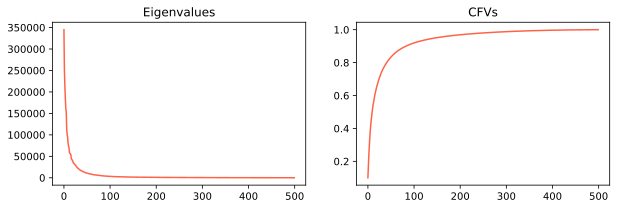

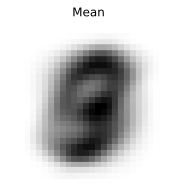

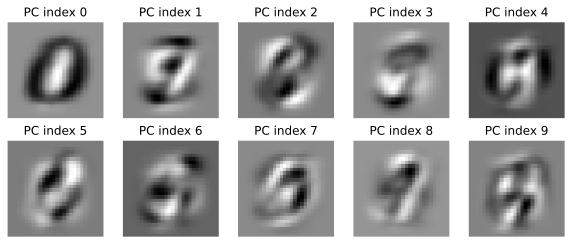

In [7]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

# print errors
err_mean, err_pcomp = calc_errs(x, pcomps)
print(f'Reconstruction error (using mean): {err_mean.item():3e}')
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp.item():3e}')

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)
